In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.8 MB/s 


In [2]:
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.models import Model
#import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [6]:
import os

In [7]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [00:50<00:00, 80.1MB/s]


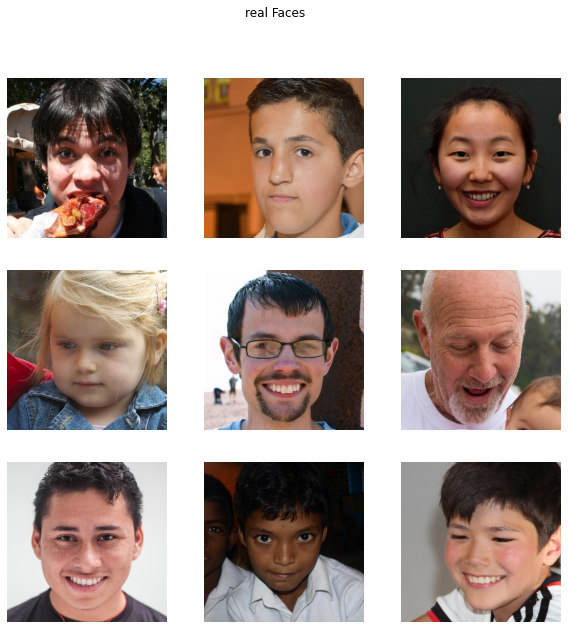

In [8]:
path = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

**FAKE SET**

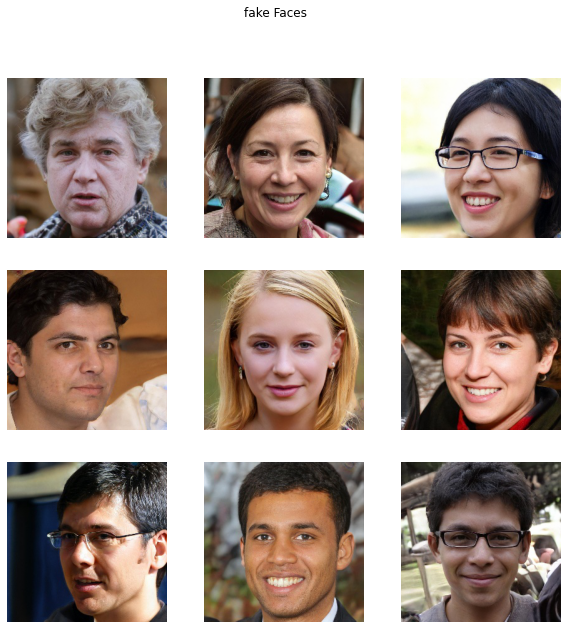

In [9]:
plot_img(path, 'fake').show()

**Train and Validation Set**

In [10]:
bs = 64
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

**Model Architecture**

In [19]:
def real_block(input, dim, drop_path=0.0):
     
     #shortcut connection
      shortcurt = input 
      x = layers.Conv2D(filters=dim, kernel_size=7, padding='same', groups=dim)(input)
      x = layers.LayerNormalization(epsilon=1e-6)(x)

      x = layers.Dense(4 * dim)(x)
      x = layers.BatchNormalization()(x)
    #   x = layers.ReLU()(x)
    #   x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    #   x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Dense(dim)(x)
      #Stochastic depth
      drop_depth = tfa.layers.StochasticDepth(drop_path) if drop_path > 0.0 else layers.Activation("linear")

      output = layers.Add()([shortcurt, drop_depth(x)])

      return output

In [20]:
def stem(input, dim):

  x = layers.Conv2D(filters=dim, kernel_size=4, strides=4)(input)
  x = layers.BatchNormalization()(x)

  return x

In [21]:
def downsampling_layers(input, dim):

#   x = layers.LayerNormalization(epsilon=1e-6)(input)
  x = layers.BatchNormalization() (input)
  x = layers.Conv2D(filters=dim, kernel_size=2, strides=2)(x)

  return x

In [22]:
def real_model(input_shape=(224, 224, 3), dims=[96, 192, 384, 768], num_classes=2):

  input = layers.Input(input_shape)

  # stem
  x = stem(input, dims[0])

  # Convnext stage 1 x3, dim[0] = 64
  for _ in range(1):
    x = real_block(x, dims[0])

  # Downsampling layers + stage 2 x3, dim[1] = 128
  x = downsampling_layers(x, dims[1])
  for _ in range(3):
    x = real_block(x, dims[1])

  # Downsampling layers + stage 3 x7, dim[2] = 256
  x = downsampling_layers(x, dims[2])
  for _ in range(6):
    x = real_block(x, dims[2])

  # Downsampling layers + stage 4 x3, dim[3] = 512
  x = downsampling_layers(x, dims[3])
  for _ in range(1):
    x = real_block(x, dims[3])
    
  # Classification head: Global average pool + layer norm + fully connected layer
  x = layers.GlobalAvgPool2D()(x)

  x = layers.LayerNormalization(epsilon=1e-6)(x)    
#   x = layers.BatchNormalization() (x)
  x = layers.Dense(units= dims[3], activation='relu') (x)
  x = layers.Dropout(0.2) (x)
  output = layers.Dense(units=num_classes, activation='softmax')(x)

  model = keras.Model(input, output, name='RealNeXt')

  return model
     
    # x = layers.BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)

**Defining Model Checkpoints**

In [23]:
model= real_model()
model.summary()

Model: "RealNeXt"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 56, 56, 96)   4704        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 56, 56, 96)  384         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                           

**Training model**

In [26]:
epochs = 20
batch_size = 100
init_lr = 1e-5
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/RealNet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')

early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.001,
                              patience =5,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [29]:
%%time
history = model.fit(training_set, validation_data = validation_set, epochs = epochs, validation_steps = 100, verbose=1)

Epoch 1/20
1563/1563 [==============================] - 1096s 690ms/step - loss: 0.6096 - accuracy: 0.6706 - val_loss: 0.5240 - val_accuracy: 0.7412
Epoch 2/20
1563/1563 [==============================] - 1080s 691ms/step - loss: 0.4279 - accuracy: 0.8052 - val_loss: 0.4084 - val_accuracy: 0.8334
Epoch 3/20
1563/1563 [==============================] - 1079s 690ms/step - loss: 0.3267 - accuracy: 0.8606 - val_loss: 0.3130 - val_accuracy: 0.8737
Epoch 4/20
1563/1563 [==============================] - 1080s 691ms/step - loss: 0.2569 - accuracy: 0.8942 - val_loss: 0.2869 - val_accuracy: 0.8805
Epoch 5/20
1563/1563 [==============================] - 1079s 690ms/step - loss: 0.2036 - accuracy: 0.9185 - val_loss: 0.3380 - val_accuracy: 0.8577
Epoch 6/20
1563/1563 [==============================] - 1079s 691ms/step - loss: 0.1674 - accuracy: 0.9342 - val_loss: 0.2369 - val_accuracy: 0.9089
Epoch 7/20
1563/1563 [==============================] - 1079s 690ms/step - loss: 0.1339 - accuracy: 0.9492

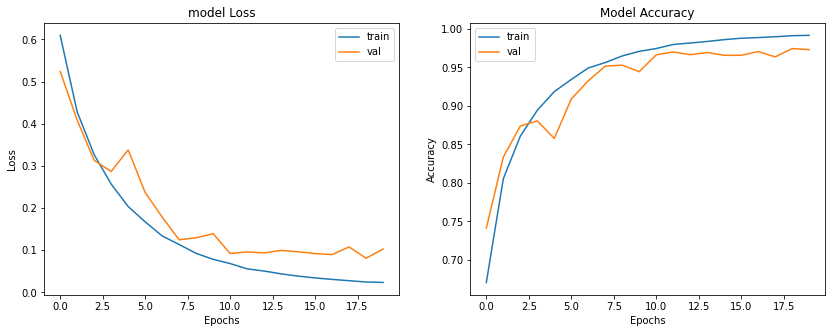

In [32]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

**Accuracy On Test Set**

In [33]:
_, accu = model.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 68s 215ms/step - loss: 0.0993 - accuracy: 0.9748
Final Test Acccuracy = 97.485


**Confusion Matrix and Classification Report**

In [43]:

base_path = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [48]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [49]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [55]:
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

In [56]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ValueError: ignored